In [89]:
import os
import json
import cv2
import numpy as np
import tensorflow.compat.v1 as tf
from run_case import real_model 
# This is the "Magic Sauce" for M4 Pro
tf.disable_eager_execution()
tf.disable_v2_behavior()
tf.disable_v2_behavior()

# Manual mapping to bypass Pylance resolution errors
placeholder = tf.placeholder
variable_scope = tf.variable_scope

# M4 PRO GPU CONFIG
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    try:
        for device in gpu_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("🚀 M4 Pro GPU (Metal) Ready")
    except Exception as e:
        print(f"⚠️ GPU setup info: {e}")

tf.compat.v1.disable_eager_execution()

🚀 M4 Pro GPU (Metal) Ready


In [90]:

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
with tf.variable_scope("test"):
    p = tf.placeholder(tf.float32, shape=[1])
    print("✅ Success! TensorFlow 1.x logic is working.")

✅ Success! TensorFlow 1.x logic is working.


In [91]:
def chair_data_generator(json_path, batch_size=1):
    with open(json_path, 'r') as f:
        data = json.load(f).get('chair', [])
    
    while True:
        np.random.shuffle(data)
        for i in range(0, len(data), batch_size):
            batch_data = data[i:i + batch_size]
            b_imgs, b_voxels = [], []
            
            for entry in batch_data:
                img = cv2.imread(entry['image_path'])
                if img is None: continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (128, 128)) / 255.0
                
                # Load (X, Y, Z) array
                voxels = np.load(entry['voxel_gt_path']).astype(np.float32)
                
                # --- PREVIOUS VERSION OF TRANSPOSE ---
                # This was the version that caused the "side-lying" chair
                # From (X, Y, Z) -> (Z, Y, X)
                voxels = voxels.transpose(2, 1, 0)
                
                if voxels.ndim == 4:
                    voxels = np.squeeze(voxels)
                
                b_imgs.append(img)
                b_voxels.append(voxels)
            
            if len(b_imgs) == batch_size:
                yield np.array(b_imgs), np.array(b_voxels)

In [92]:
with open("pascal_metadata_training_fixed.json", 'r') as f:
    data = json.load(f).get('chair', [])
# Check the first 5 samples
for i in range(min(5, len(data))):
    voxel_path = data[i]['voxel_gt_path']
    if os.path.exists(voxel_path):
        voxels = np.load(voxel_path)
        
        print(f"File: {os.path.basename(voxel_path)}")
        print(f"  - Shape: {voxels.shape}")
        print(f"  - Dtype: {voxels.dtype}")
        print(f"  - Min Value: {np.min(voxels)}")
        print(f"  - Max Value: {np.max(voxels)}")
        print(f"  - Unique Values: {np.unique(voxels)}")
        print("-" * 30)

File: chair_01.npy
  - Shape: (32, 32, 32)
  - Dtype: uint8
  - Min Value: 0
  - Max Value: 1
  - Unique Values: [0 1]
------------------------------
File: chair_08.npy
  - Shape: (32, 32, 32)
  - Dtype: uint8
  - Min Value: 0
  - Max Value: 1
  - Unique Values: [0 1]
------------------------------
File: chair_05.npy
  - Shape: (32, 32, 32)
  - Dtype: uint8
  - Min Value: 0
  - Max Value: 1
  - Unique Values: [0 1]
------------------------------
File: chair_05.npy
  - Shape: (32, 32, 32)
  - Dtype: uint8
  - Min Value: 0
  - Max Value: 1
  - Unique Values: [0 1]
------------------------------
File: chair_09.npy
  - Shape: (32, 32, 32)
  - Dtype: uint8
  - Min Value: 0
  - Max Value: 1
  - Unique Values: [0 1]
------------------------------


In [93]:
#Clear the background graph to prevent "Variable already exists" 
tf.compat.v1.reset_default_graph()
checkpoint_path = "/Users/nehir/Desktop/psvh_model_weights/23501.cptk"

# 2. Define Model and Tensors
# v_after shape: [1, 32, 32, 32]
v_before, v_after, img_ph = real_model()
gt_ph = tf.compat.v1.placeholder(tf.float32, [None, 32, 32, 32], name="vox_gt")

"""NEXT TO TRY # Give '1' values (chair) 10x more importance than '0' values (air)
weights = gt_ph * 10.0 + (1.0 - gt_ph) * 1.0
loss = tf.reduce_mean(tf.square(v_after - gt_ph) * weights) """

# 3. Define Loss and Optimizer
loss = tf.reduce_mean(tf.square(v_after - gt_ph))
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

# --- CRITICAL FIX: VARIABLE MANAGEMENT ---

# Identify which variables belong to the MODEL (to be restored) 
# and which belong to the OPTIMIZER (to be initialized)
all_vars = tf.compat.v1.global_variables()
model_vars = [v for v in all_vars if 'Adam' not in v.name and 'beta' not in v.name]
optimizer_vars = [v for v in all_vars if 'Adam' in v.name or 'beta' in v.name]

# Create saver for the model weights ONLY
saver = tf.compat.v1.train.Saver(var_list=model_vars)

# 4. Session Execution
sess = tf.compat.v1.Session()

# Initialize ONLY the new optimizer variables (so we don't overwrite the model)
if optimizer_vars:
    sess.run(tf.compat.v1.variables_initializer(optimizer_vars))
else:
    # Fallback if no optimizer vars found yet
    sess.run(tf.compat.v1.global_variables_initializer())

print(f"📡 Restoring weights from {checkpoint_path}...")
try:
    saver.restore(sess, checkpoint_path)
    print("✅ Weights Loaded Successfully")
except Exception as e:
    print(f"❌ Restore failed: {e}")
    print("Hint: Check if the checkpoint path is correct or if model architecture changed.")


pool1 Tensor("voxel/encoder/MaxPool:0", shape=(1, 64, 64, 96), dtype=float32)
pool2 Tensor("voxel/encoder/MaxPool_1:0", shape=(1, 32, 32, 128), dtype=float32)
pool3 Tensor("voxel/encoder/MaxPool_2:0", shape=(1, 16, 16, 256), dtype=float32)
pool4 Tensor("voxel/encoder/MaxPool_3:0", shape=(1, 8, 8, 256), dtype=float32)
pool5 Tensor("voxel/encoder/MaxPool_4:0", shape=(1, 4, 4, 256), dtype=float32)
pool6 Tensor("voxel/encoder/Mean:0", shape=(1, 256), dtype=float32)
feature Tensor("voxel/encoder/MatMul:0", shape=(1, 1024), dtype=float32)
feature_map Tensor("voxel/encoder/MaxPool_5:0", shape=(1, 2, 2, 256), dtype=float32)
Tensor("voxel/encoder/MatMul:0", shape=(1, 1024), dtype=float32)
Tensor("voxel/decoder/Reshape:0", shape=(1, 1, 1, 1, 1024), dtype=float32)
d1 Tensor("voxel/decoder/Relu:0", shape=(1, 4, 4, 4, 256), dtype=float32)
d2 Tensor("voxel/decoder/Add:0", shape=(1, 8, 8, 8, 128), dtype=float32)
d3 Tensor("voxel/decoder/Add_1:0", shape=(1, 16, 16, 16, 64), dtype=float32)
d4 Tensor("v

2026-01-23 23:18:30.951201: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-23 23:18:30.951217: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


📡 Restoring weights from /Users/nehir/Desktop/psvh_model_weights/23501.cptk...
INFO:tensorflow:Restoring parameters from /Users/nehir/Desktop/psvh_model_weights/23501.cptk
✅ Weights Loaded Successfully


In [94]:
# Check a specific weight to see if it's actually loaded or just random
test_var = [v for v in tf.compat.v1.global_variables() if "wd00" in v.name][0]
weight_values = sess.run(test_var)

print(f"Variable Name: {test_var.name}")
print(f"Weight Mean: {np.mean(weight_values)}")
print(f"Weight Max: {np.max(weight_values)}")

if np.abs(np.mean(weight_values)) < 1e-7:
    print("❌ ERROR: Weights are all zeros or uninitialized!")
else:
    print("✅ Weights appear to be loaded.")

Variable Name: voxel/encoder/wd00:0
Weight Mean: 1.9196944776922464e-05
Weight Max: 0.10852489620447159
✅ Weights appear to be loaded.


In [95]:
JSON_PATH = "pascal_metadata_training_fixed.json"
EPOCHS = 5
STEPS_PER_EPOCH = 200 
BATCH_SIZE = 1

gen = chair_data_generator(JSON_PATH, BATCH_SIZE)

import os

# 1. Update the Placeholder to handle dynamic batch sizes
# (If your real_model() fixed the batch at 1, we need to redefine img_ph)
# Assuming img_ph was created inside real_model, ensure it supports batch size 4.

# 2. Create a NEW saver for saving the WHOLE state (Model + Optimizer)
# This is different from the restoration saver we used earlier
final_saver = tf.compat.v1.train.Saver() 

print("🚀 Starting Fine-tuning on M4 Pro...")

for epoch in range(EPOCHS):
    epoch_loss = 0
    for step in range(STEPS_PER_EPOCH):
        try:
            batch_imgs, batch_gt = next(gen)
            
            # Run optimization
            _, l = sess.run([optimizer, loss], feed_dict={
                img_ph: batch_imgs,
                gt_ph: batch_gt
            })
            
            epoch_loss += l
            
            if (step + 1) % 10 == 0:
                print(f"  Step {step+1}/{STEPS_PER_EPOCH} | Current Loss: {l:.5f}")
                
        except Exception as e:
            print(f"❌ Error at Step {step}: {e}")
            continue

    avg_loss = epoch_loss / STEPS_PER_EPOCH
    print(f"✅ Epoch {epoch+1} Complete | Avg Loss: {avg_loss:.5f}")

# 3. Save the result
save_path = "./finetuned_chair_model.cptk"
final_saver.save(sess, save_path)
print(f"💾 Model saved to {save_path}")

🚀 Starting Fine-tuning on M4 Pro...
  Step 10/200 | Current Loss: 0.03055
  Step 20/200 | Current Loss: 0.02633
  Step 30/200 | Current Loss: 0.02052
  Step 40/200 | Current Loss: 0.02045
  Step 50/200 | Current Loss: 0.02198
  Step 60/200 | Current Loss: 0.01687
  Step 70/200 | Current Loss: 0.02006
  Step 80/200 | Current Loss: 0.03239
  Step 90/200 | Current Loss: 0.01600
  Step 100/200 | Current Loss: 0.01649
  Step 110/200 | Current Loss: 0.01569
  Step 120/200 | Current Loss: 0.06540
  Step 130/200 | Current Loss: 0.02990
  Step 140/200 | Current Loss: 0.01840
  Step 150/200 | Current Loss: 0.02539
  Step 160/200 | Current Loss: 0.02089
  Step 170/200 | Current Loss: 0.01774
  Step 180/200 | Current Loss: 0.01863
  Step 190/200 | Current Loss: 0.01554
  Step 200/200 | Current Loss: 0.02153
✅ Epoch 1 Complete | Avg Loss: 0.02757
  Step 10/200 | Current Loss: 0.06225
  Step 20/200 | Current Loss: 0.01974
  Step 30/200 | Current Loss: 0.01413
  Step 40/200 | Current Loss: 0.02124
  

In [96]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_voxels(voxels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Render the cubes (True values)
    ax.voxels(voxels, edgecolor='k', facecolors='coral', alpha=0.7)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z') 
    plt.title("Fine-tuned PSVH Chair Result")
    plt.show()


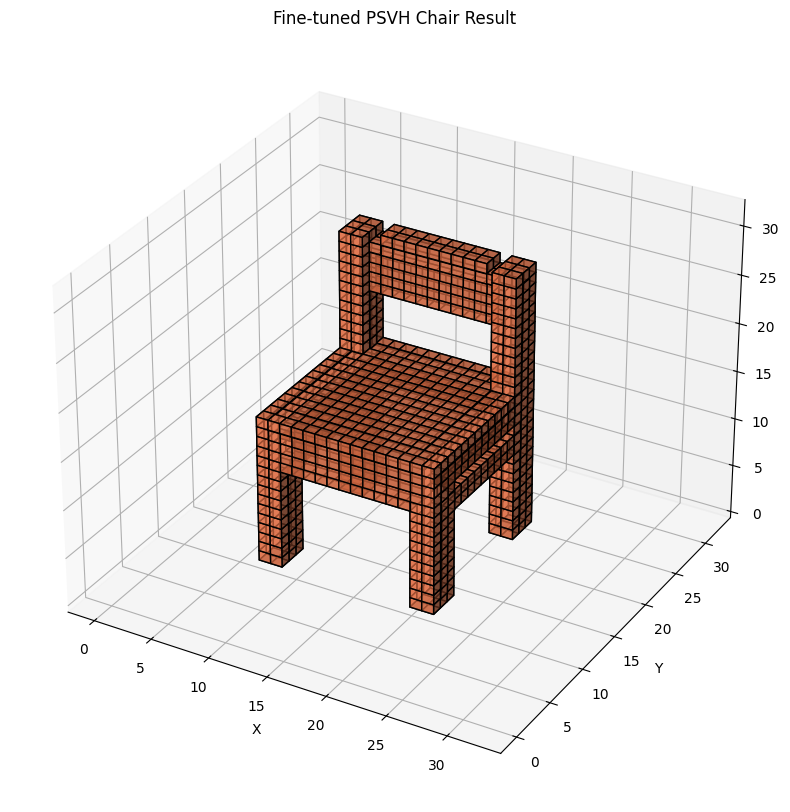

In [134]:
voxel_trial = np.load("/Users/nehir/Desktop/psvh_finetuning/voxels/chair_01.npy").astype(np.float32)
visualize_voxels(voxel_trial)

Prediction Max Value: 0.9757018089294434


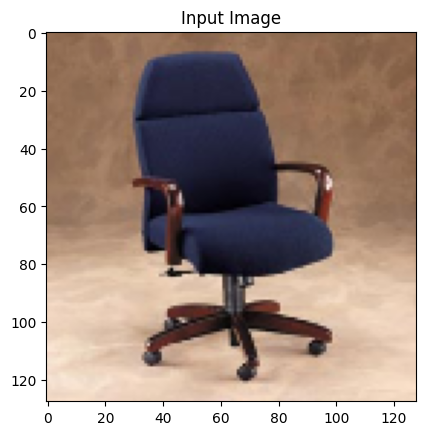

Visualizing shape at threshold: 0.7
📊 Volume Audit:
  - Prediction volume: 1303 voxels
  - GT volume: 1450 voxels
  - Intersection: 1187 voxels
  - Current IoU: 0.7580


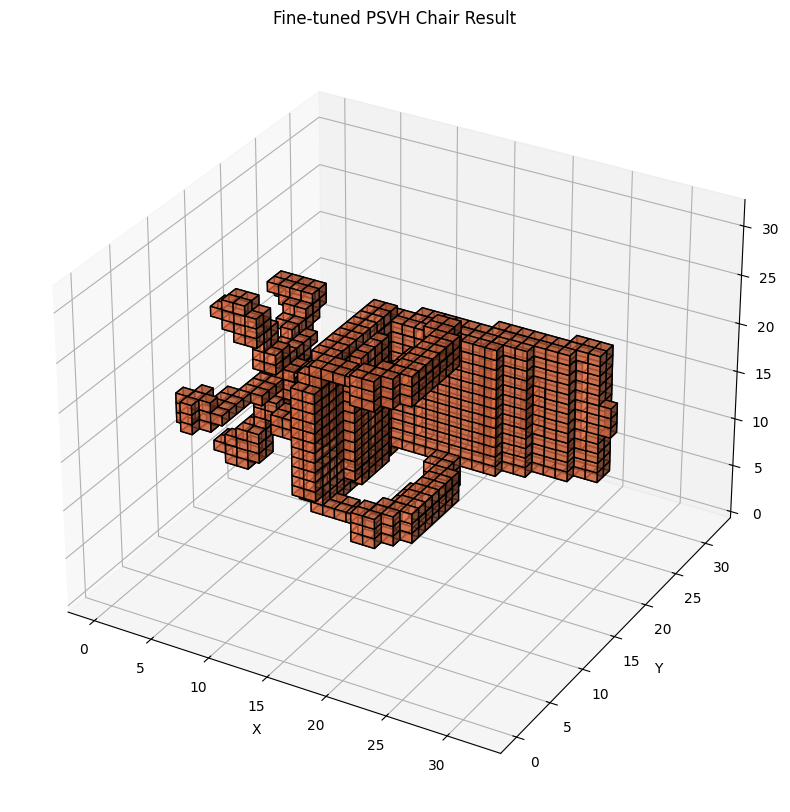

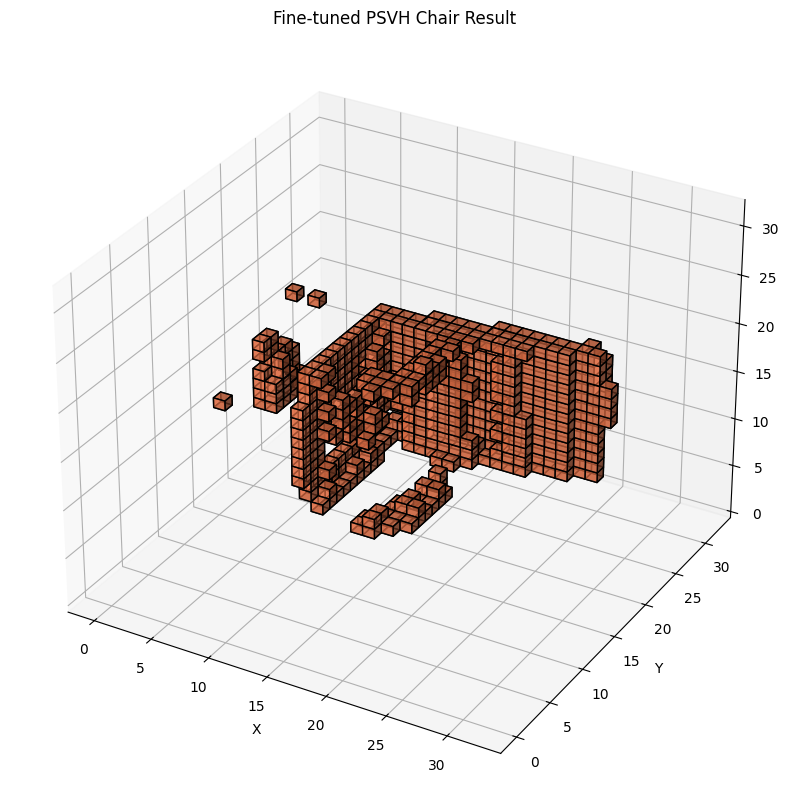

In [152]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Get a test sample from your generator
test_batch_imgs, test_batch_gt = next(gen)

# 2. RETRIEVE VALUES: Tell the session to calculate the 'v_after' tensor
# feeding the test image into the 'img_ph' placeholder
prediction = sess.run(v_after, feed_dict={img_ph: test_batch_imgs})

# 'prediction' is now a NumPy array of values, NOT a tensor.
# Its shape will be (1, 32, 32, 32)

# 3. Check the "Strength" of the prediction
max_val = np.max(prediction[0])
print(f"Prediction Max Value: {max_val}")

# 4. Display the Input Image
plt.imshow(test_batch_imgs[0])
plt.title("Input Image")
plt.show()

# Try transposing the result to see which one stands it up
# (0, 1, 2, 3) -> (Batch, Z, Y, X). Let's try (Batch, X, Z, Y)

# 5. Visualize the result
# If max_val is 0.00008, the chair is "invisible" at 0.4.
# We use an adaptive threshold to see if ANY shape was formed.


if max_val > 0:
    # Use 50% of the max strength to see the shape
    threshold = 0.7
    print(f"Visualizing shape at threshold: {threshold}")
    # 1. Get a batch


    # 3. Apply the transposes to ALIGN them both to the "upright" view
    pred_upright = prediction[0].transpose(2, 1, 0)
    gt_upright = test_batch_gt[0].transpose(2, 1, 0) 

    # --- INSERT DIAGNOSTIC BLOCK HERE ---
    intersection = np.logical_and(pred_upright > 0.4, gt_upright > 0.5).sum()
    pred_size = (pred_upright > 0.4).sum()
    gt_size = (gt_upright > 0.5).sum()

    print(f"📊 Volume Audit:")
    print(f"  - Prediction volume: {pred_size} voxels")
    print(f"  - GT volume: {gt_size} voxels")
    print(f"  - Intersection: {intersection} voxels")
    print(f"  - Current IoU: {intersection / (pred_size + gt_size - intersection + 1e-7):.4f}")

    if pred_size > 0 and gt_size > pred_size * 2:
        print("🚩 SCALE ALERT: Your GT is much larger than your prediction!")
    elif pred_size > 0 and intersection < (pred_size * 0.1):
        print("🚩 ALIGNMENT ALERT: Volumes exist but they aren't touching. Check for 1-voxel shifts!")
    # -------------------------------------

    visualize_voxels(test_batch_gt[0])
    visualize_voxels(pred_upright.transpose(2,1,0) > threshold)
else:
    print("The model output is completely empty.")

In [147]:
import numpy as np
# Load the JSON metadata
with open(JSON_PATH, 'r') as f:
    full_data = json.load(f)

# data_list is the list of dictionaries inside the 'chair' category
data_list = full_data.get('chair', [])

print(f"Total samples in data_list: {len(data_list)}")

def calculate_iou_score(pred_binary, gt_binary):
    """Calculates IoU for two binary boolean arrays."""
    intersection = np.logical_and(pred_binary, gt_binary).sum()
    union = np.logical_or(pred_binary, gt_binary).sum()
    if union == 0:
        return 0.0
    return intersection / union

def evaluate_model_iou(generator, session, v_after_tensor, img_placeholder, num_samples=100, threshold=0.4):
    ious = []
    print(f"🧐 Evaluating Average IoU over {num_samples} samples...")

    for i in range(num_samples):
        # 1. Get data from generator
        img_batch, gt_batch = next(generator)
        
        # 2. Get model prediction
        # Output shape: (1, 32, 32, 32)
        raw_pred = session.run(v_after_tensor, feed_dict={img_placeholder: img_batch})[0]
        
        # 3. ALIGNMENT: Transpose the prediction to match your 'upright' coordinate system
        # You confirmed (2, 1, 0) is the correct orientation for your visualizer/GT
        pred_upright = raw_pred.transpose(2, 1, 0)
        
        # 4. Prepare binary masks
        pred_binary = pred_upright > threshold
        gt_binary = gt_batch[0] > 0.5  # Assuming GT is already aligned correctly
        
        
        # 5. Calculate and store
        score = calculate_iou_score(pred_binary, gt_binary)
        ious.append(score)
        
        if (i + 1) % 20 == 0:
            print(f"   Processed {i+1}/{num_samples} | Current Mean IoU: {np.mean(ious):.4f}")

    final_mean_iou = np.mean(ious)
    print(f"\n✅ Final Average IoU: {final_mean_iou:.4f}")
    return final_mean_iou

# --- EXECUTION ---
# Ensure 'v_after' and 'img_ph' are the tensors from your real_model()
avg_iou = evaluate_model_iou(
    generator=gen, 
    session=sess, 
    v_after_tensor=v_after, 
    img_placeholder=img_ph, 
    num_samples=len(data_list) # Or a fixed number like 100
)

Total samples in data_list: 1089
🧐 Evaluating Average IoU over 1089 samples...
   Processed 20/1089 | Current Mean IoU: 0.0904


KeyboardInterrupt: 